# Introduction

In this competition, we are tasked with developing accurate predictions of metered building energy usage in the following areas: chilled water, electric, natural gas, hot water, and steam meters. The data comes from over 1,000 buildings over a 3-year timeframe.

The aim is that with better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

# The Data

There are five files that have been provided and also a sample submission file.

The five primary files to be used are described below, with the variable names also included:


**train.csv**:

`building_id` - Foreign key for the building metadata.

`meter` - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

`timestamp` - When the measurement was taken

`meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.


**building_meta.csv**:

`site_id` - Foreign key for the weather files.

`building_id` - Foreign key for training.csv

`primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions

`square_feet` - Gross floor area of the building

`year_built` - Year building was opened

`floor_count` - Number of floors of the building


**weather_[train/test].csv**:

Weather data from a meteorological station as close as possible to the site.

`site_id`

`air_temperature` - Degrees Celsius

`cloud_coverage` - Portion of the sky covered in clouds, in oktas

`dew_temperature` - Degrees Celsius

`precip_depth_1_hr` - Millimeters

`sea_level_pressure` - Millibar/hectopascals

`wind_direction` - Compass direction (0-360)

`wind_speed` - Meters per second


**test.csv**

The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

`row_id` - Row id for your submission file

`building_id` - Building id code

`meter` - The meter id code

`timestamp` - Timestamps for the test data period


In [1]:
# load in libraries
library(tidyverse)
library(scales)
library(lubridate) #dealing with datetime
library(ggridges) #geometric plots

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.1     ✔ dplyr   0.8.4
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date



In [2]:
# set plotting theme baseline
theme_set(theme_minimal() +
            theme(axis.title.x = element_text(size = 15, hjust = 1),
                  axis.title.y = element_text(size = 15),
                  axis.text.x = element_text(size = 12),
                  axis.text.y = element_text(size = 12),
                  panel.grid.major = element_line(linetype = 2),
                  panel.grid.minor = element_line(linetype = 2),
                  plot.title = element_text(size = 18, colour = "grey25", face = "bold"), plot.subtitle = element_text(size = 16, colour = "grey44")))

col_pal <- c("#5EB296", "#4E9EBA", "#F29239", "#C2CE46", "#FF7A7F", "#4D4D4D")

In [3]:
# read in data
train <- data.table::fread("/Users/rohinigoel/Downloads/ashrae-energy-prediction/train.csv")
# test <- read.csv("data/ashrae-energy-prediction/test.csv", stringsAsFactors = F)
# 
# # # add column to train and test to indicate which df they are when joined
# train$df <- "train"
# test$df <- "test"
# 
# train_test <- bind_rows(train, test)
# rm(train, test);gc()

building <- read.csv("/Users/rohinigoel/Downloads/ashrae-energy-prediction/building_metadata.csv")

In [4]:
weather_train <- read.csv("/Users/rohinigoel/Downloads/ashrae-energy-prediction/weather_train.csv")
# weather_test <- read.csv("/Users/rohinigoel/Downloads/ashrae-energy-prediction/weather_test.csv", stringsAsFactors = F)
# 
# weather <- bind_rows(weather_train, weather_test)
# rm(weather_train, weather_test);gc()

# samp_sub <- weather_train <- read.csv("/Users/rohinigoel/Downloads/ashrae-energy-prediction/sample_submission.csv", stringsAsFactors = F)

In [5]:
# # join all data into one complete file
# combined_df <- train_test %>%
#   left_join(building, by = "building_id") %>%
#   left_join(weather, by = c("site_id", "timestamp"))
# 
# rm(train_test, weather, building);gc()

In [6]:
# join all data into one complete file
combine_train <- train %>%
  left_join(building, by = "building_id") %>%
  left_join(weather_train, by = c("site_id", "timestamp"))

Warning message:
“Column `timestamp` joining character vector and factor, coercing into character vector”

# Feature Engineering

The code block below will be expanded on over time as I come up with some new features.

Engineered features include:

* Month of the year
* Day of the week of the timestamp
* Hour of the day

In [7]:
combine_train <- combine_train %>% 
  mutate(timestamp_date = ymd(gsub( " .*$", "", timestamp)),
         timestamp_month = month(timestamp_date),
         timestamp_day = wday(timestamp_date, label = T, abbr = T),
         timestamp_day_number = day(timestamp_date),
         time_ymd_hms = ymd_hms(timestamp),
         time_hour = hour(time_ymd_hms))

# Exploratory Data Analysis (EDA)

To conduct the following analysis, the `train`, `building` and `weather_train` datasets have been joined. We tried combining the training and testing sets together, but found processing time for the following EDA to be slowed down considerably, so will replicate any cleaning / feature engineering conducted on the `train` to the `test` set.

The joined dataframe (`combine_train`) now has `r comma(nrow(combine_train))` rows, and `r ncol(combine_train)` columns.

## Missing Data

The missing data is shown below. The observations with missing weather and building variables will need to be investigated throughout the report

In [8]:
colSums(is.na(combine_train))

building_id                meter            timestamp 
                   0                    0                    0 
       meter_reading              site_id          primary_use 
                   0                    0                    0 
         square_feet           year_built          floor_count 
                   0             12127645             16709167 
     air_temperature       cloud_coverage      dew_temperature 
               96658              8825365               100140 
   precip_depth_1_hr   sea_level_pressure       wind_direction 
             3749023              1231669              1449048 
          wind_speed       timestamp_date      timestamp_month 
              143676                    0                    0 
       timestamp_day timestamp_day_number         time_ymd_hms 
                   0                    0                    0 
           time_hour 
                   0

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


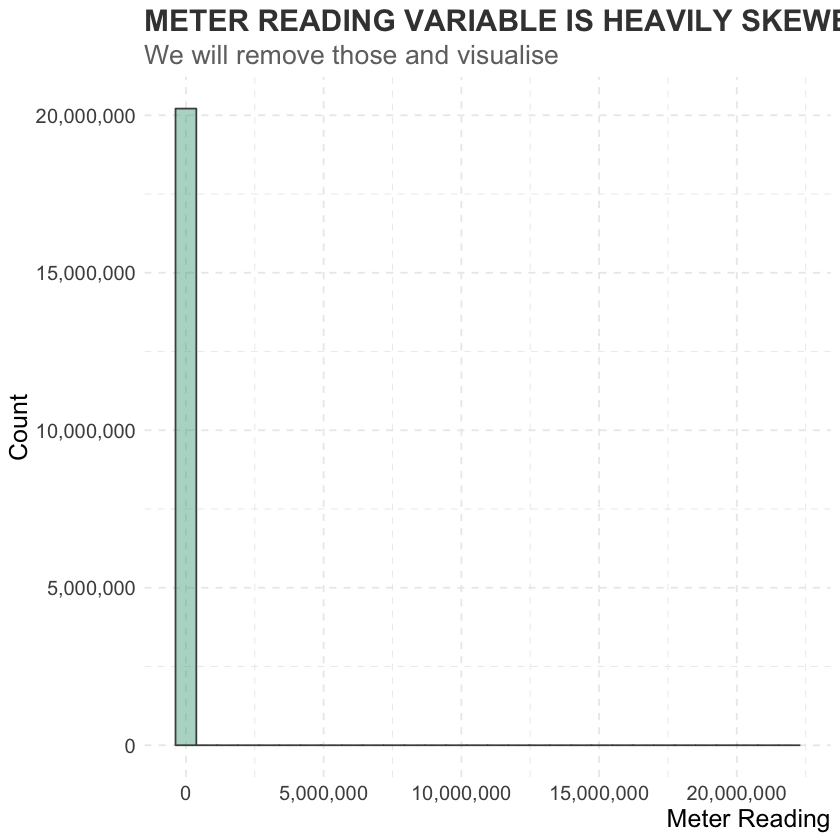

In [9]:
## Target Variable Analysis - `meter_reading`

combine_train %>% 
  ggplot(aes(x=meter_reading)) +
  geom_histogram(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  scale_x_continuous(labels = comma) +
  scale_y_continuous(labels = comma) +
  ggtitle("METER READING VARIABLE IS HEAVILY SKEWED BY SOME OUTLIERS", subtitle = "We will remove those and visualise") +
  labs(x= "Meter Reading", y= "Count")

In [10]:
summary(combine_train$meter_reading)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
       0       18       79     2117      268 21904700 

To visualise the distribution of `meter_reading` without outliers, we will split those outliers used by the formula (1.5 x IQR).

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


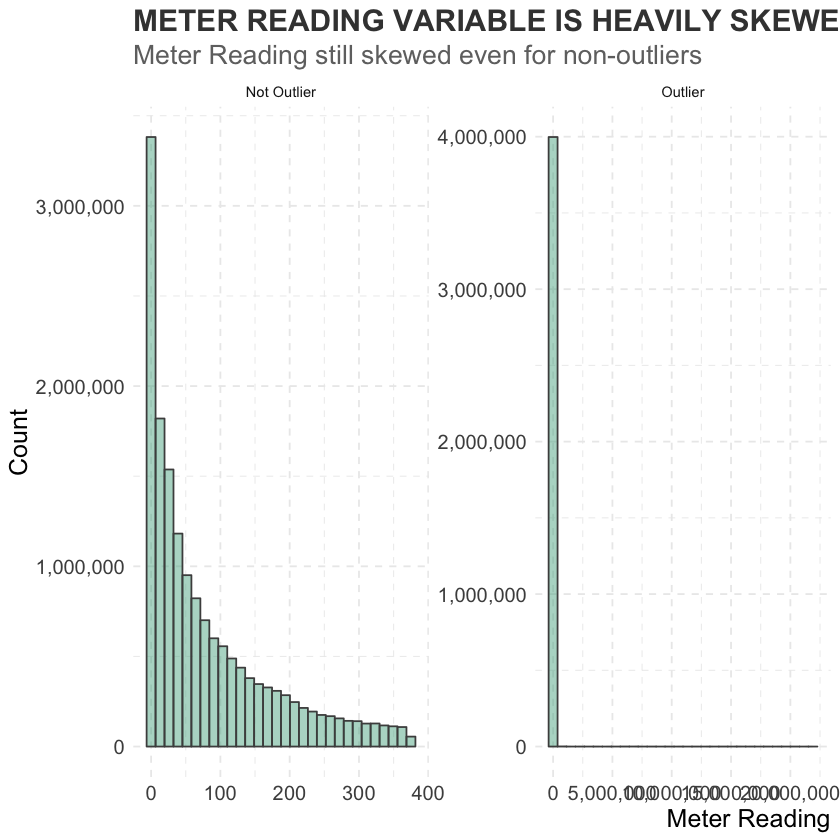

In [11]:
outlier <- round(1.5 * IQR(combine_train$meter_reading),0) #Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers). Add 1.5 x (IQR) to the third quartile. Any number greater than this is a suspected outlier. Subtract 1.5 x (IQR) from the first quartile
combine_train %>% 
  mutate(outlier = ifelse(meter_reading > outlier, "Outlier", "Not Outlier")) %>% 
  ggplot(aes(x=meter_reading)) +
  geom_histogram(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  scale_x_continuous(labels = comma) +
  scale_y_continuous(labels = comma) +
  ggtitle("METER READING VARIABLE IS HEAVILY SKEWED", subtitle = "Meter Reading still skewed even for non-outliers") +
  labs(x= "Meter Reading", y= "Count") +
  facet_wrap(~ outlier, scales = "free")

As we can see, the target variable is still heavily skewed, even for those observations within the outlier cutoff.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


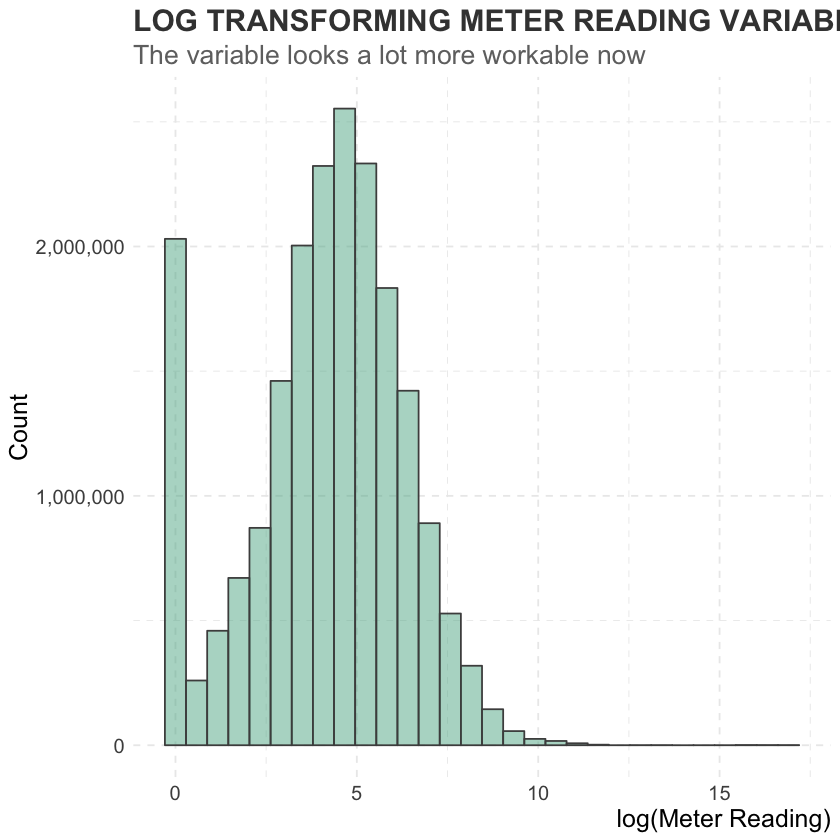

In [12]:
#We will definitely be performing some transformations on `meter_reading` for modelling purposes - see below:

combine_train %>% 
  ggplot(aes(x= log(meter_reading + 1))) +
  geom_histogram(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  scale_y_continuous(labels = comma) +
  ggtitle("LOG TRANSFORMING METER READING VARIABLE IS NECESSARY", subtitle = "The variable looks a lot more workable now") +
  labs(x= "log(Meter Reading)", y= "Count")

### Meter Reading and Meter Type


There are four different meter types and are displayed below:

* 0: electricity
* 1: chilledwater 
* 2: steam
* 3: hotwater


We can see that the `hotwater` meter type tends to have higher meter readings, while `electricity` tends to have the lowest energy readings.

In [ ]:
combine_train %>% 
  ggplot(aes(x= log(meter_reading + 1), fill = as.character(meter))) +
  geom_density(alpha = 0.5, adjust = 2) +
  scale_fill_manual(values = col_pal) +
  ggtitle("THE HOTWATER METER TYPE IS THE LEAST EFFICIENT, ELECTRICITY\nTHE MOST EFFICIENT", subtitle = "Meter readings of 0 have been excluded") +
  labs(x= "log(Meter Reading)") +
  theme(axis.title.y = element_blank(), legend.position = "top")

### Weekday and Meter Reading

I suppose it's to be expected, Sundays tend to generally have lower readings, but there isn't a major difference between the days

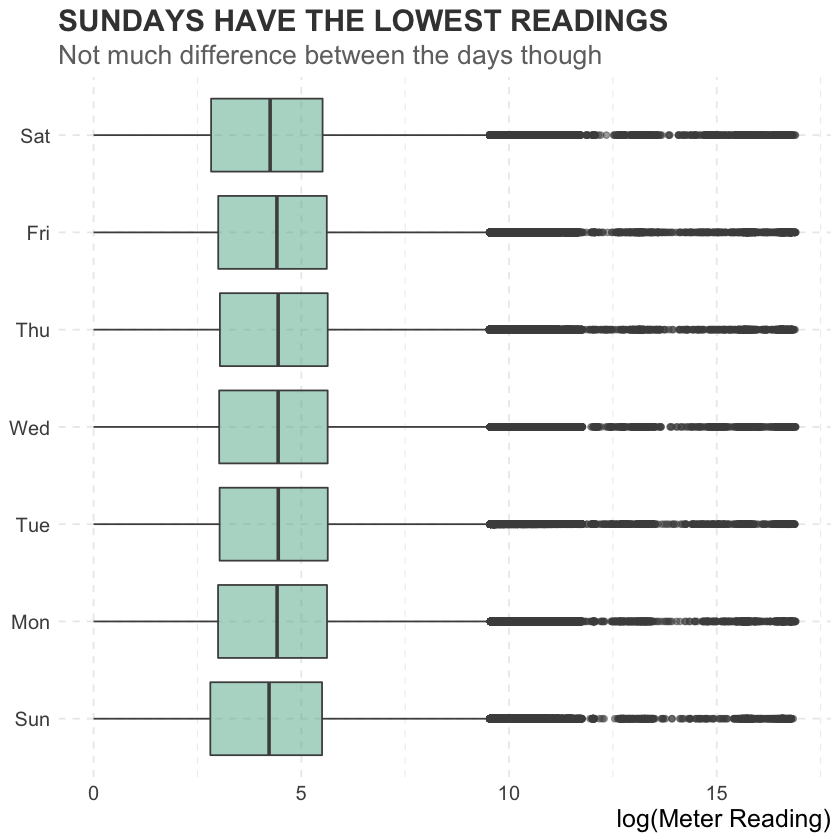

In [14]:
combine_train %>% 
  ggplot(aes(x= timestamp_day, y= log(meter_reading + 1))) +
  geom_boxplot(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  ggtitle("SUNDAYS HAVE THE LOWEST READINGS", subtitle = "Not much difference between the days though") +
  labs(y= "log(Meter Reading)") +
  coord_flip() +
  theme(axis.title.y = element_blank())

### Time of Day and Meter Reading

Reading are significantly higher during traditional work hours and this is to be expected. Time of day appears like it will be a significant predictor in any subsequent model for this competition.

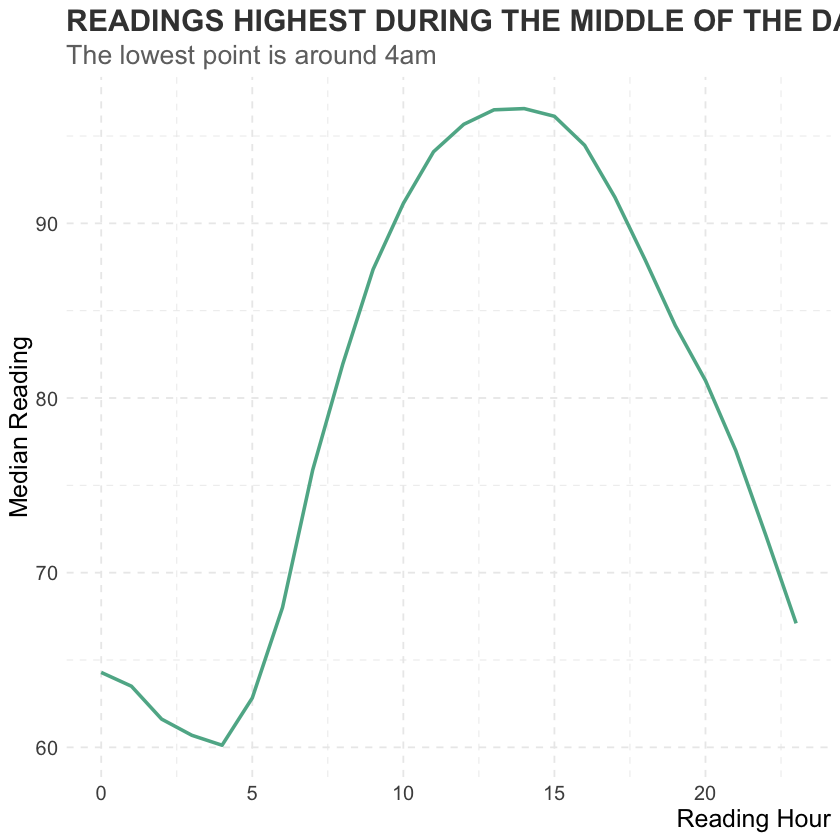

In [15]:
combine_train %>% 
  group_by(time_hour) %>% 
  summarise(median_reading = median(meter_reading, na.rm = T)) %>% 
  ggplot(aes(x= time_hour, y= median_reading)) +
  geom_line(colour = "#5EB296", size = 1) +
  ggtitle("READINGS HIGHEST DURING THE MIDDLE OF THE DAY", subtitle = "The lowest point is around 4am") +
  labs(x= "Reading Hour", y= "Median Reading")

There are considerable differences between building types as to when meter readings are highest. Healthcare buildings peak slightly later in the day, while Housing peaks from about 7pm. Manufacturing has higher readings earlier than the average, while Utility peaks before 5am.

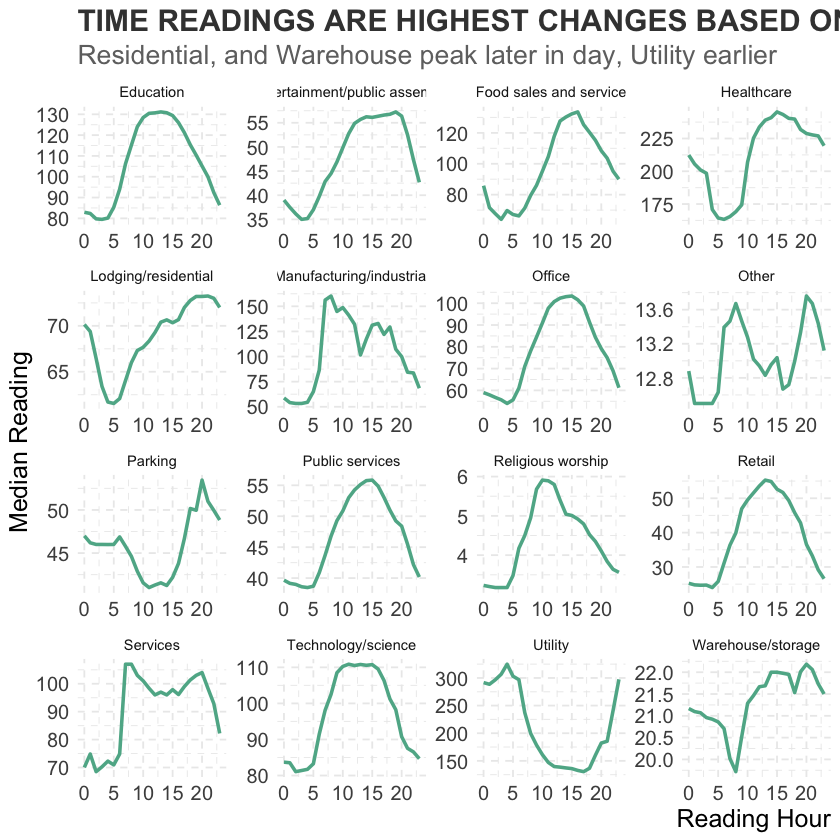

In [16]:
combine_train %>% 
  group_by(time_hour, primary_use) %>% 
  summarise(median_reading = median(meter_reading, na.rm = T)) %>% 
  ggplot(aes(x= time_hour, y= median_reading)) +
  geom_line(colour = "#5EB296", size = 1) +
  ggtitle("TIME READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE", subtitle = "Residential, and Warehouse peak later in day, Utility earlier") +
  labs(x= "Reading Hour", y= "Median Reading") +
  facet_wrap(~ primary_use, scales = "free")

Primary Use and Meter Reading

We can see that `Utility` and `Healthcare` places tend to have the highest readings, while Religious Worship places the least - they're no doubt frequented less often than the higher energy users.

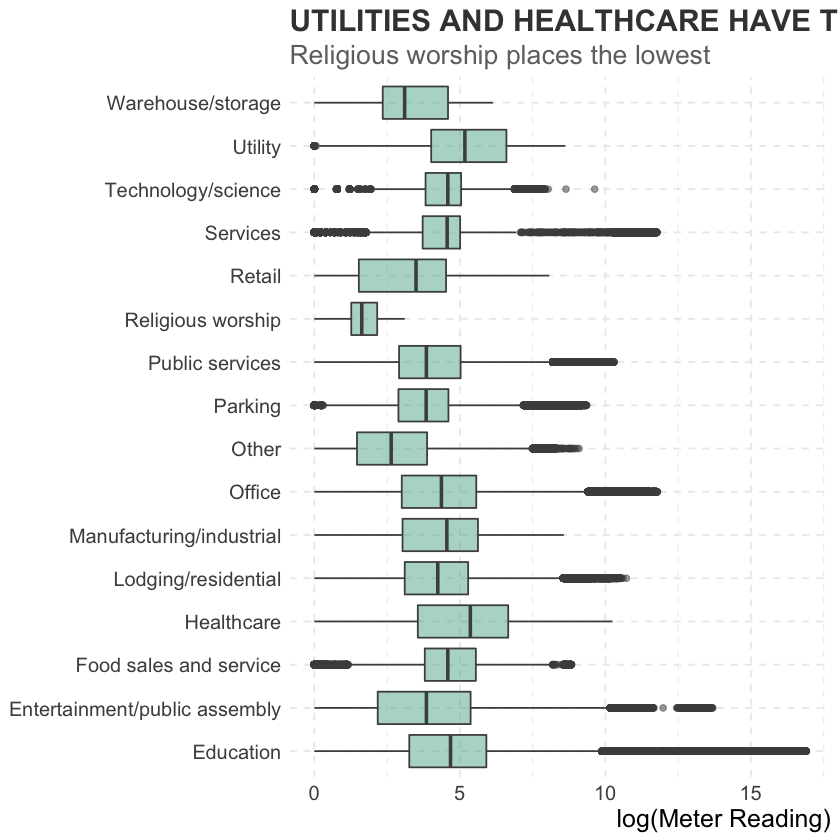

In [17]:
combine_train %>% 
  ggplot(aes(x= as.character(primary_use), y= log(meter_reading + 1))) +
  geom_boxplot(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  ggtitle("UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS", subtitle = "Religious worship places the lowest") +
  labs(y= "log(Meter Reading)") +
  coord_flip() +
  theme(axis.title.y = element_blank())

It's interesting to see that different building types have different energy usage on different days - religious places have higher readings on weekends compared to the average, while places of industry (businesses) have higher readings on weekdays.

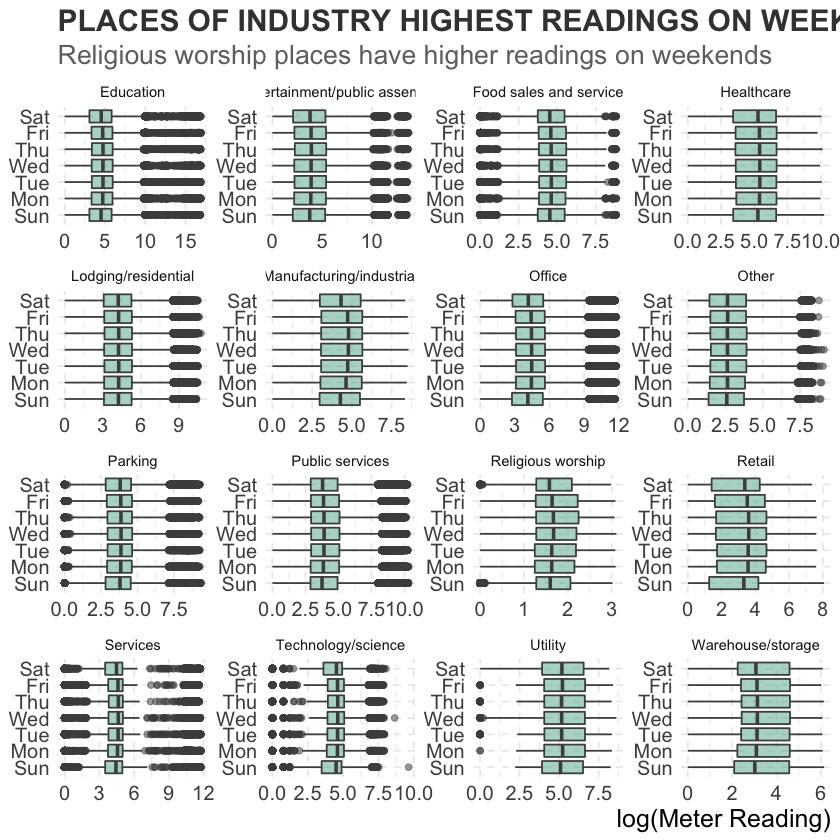

In [18]:
combine_train %>% 
  ggplot(aes(x= timestamp_day, y= log(meter_reading + 1))) +
  geom_boxplot(alpha = 0.5, fill = "#5EB296", colour = "#4D4D4D") +
  ggtitle("PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS", subtitle = "Religious worship places have higher readings on weekends") +
  labs(y= "log(Meter Reading)") +
  coord_flip() +
  theme(axis.title.y = element_blank()) +
  facet_wrap(~ primary_use, scales = "free")

### Meter Readings over time

Interestingly, the median meter reading per reading began rising in May and peaked between July and October 2016.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


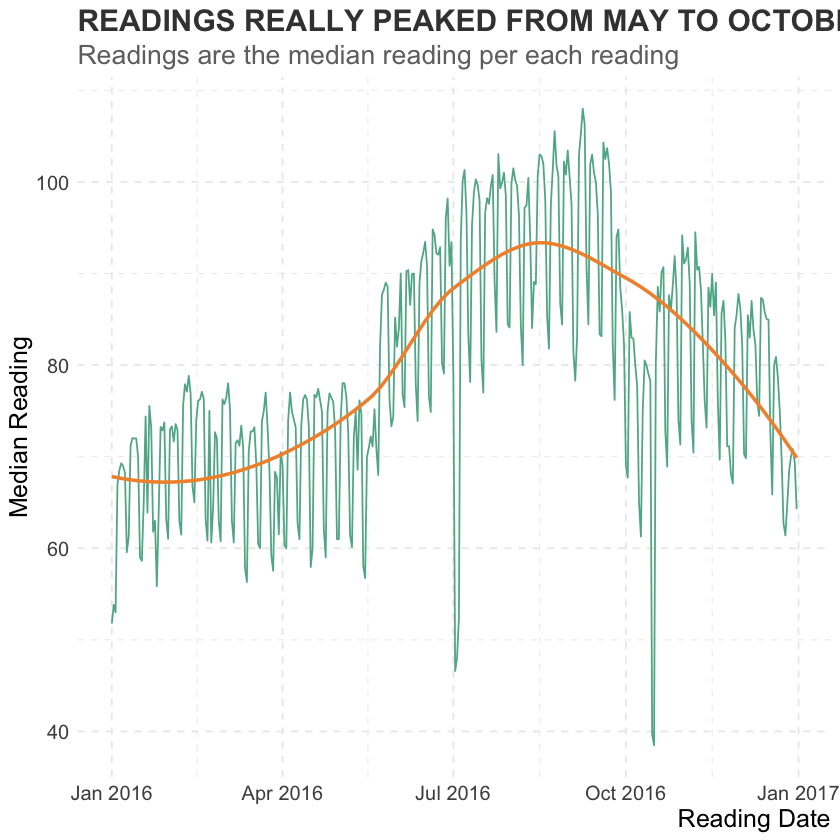

In [19]:
combine_train %>% 
  group_by(timestamp_date) %>% 
  summarise(median_reading = median(meter_reading, na.rm = T)) %>% 
  ggplot(aes(x= timestamp_date, y= median_reading)) +
  geom_line(colour = "#5EB296") +
  geom_smooth(se = F, colour = col_pal[3]) +
  ggtitle("READINGS REALLY PEAKED FROM MAY TO OCTOBER", subtitle = "Readings are the median reading per each reading") +
  labs(x= "Reading Date", y= "Median Reading")

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


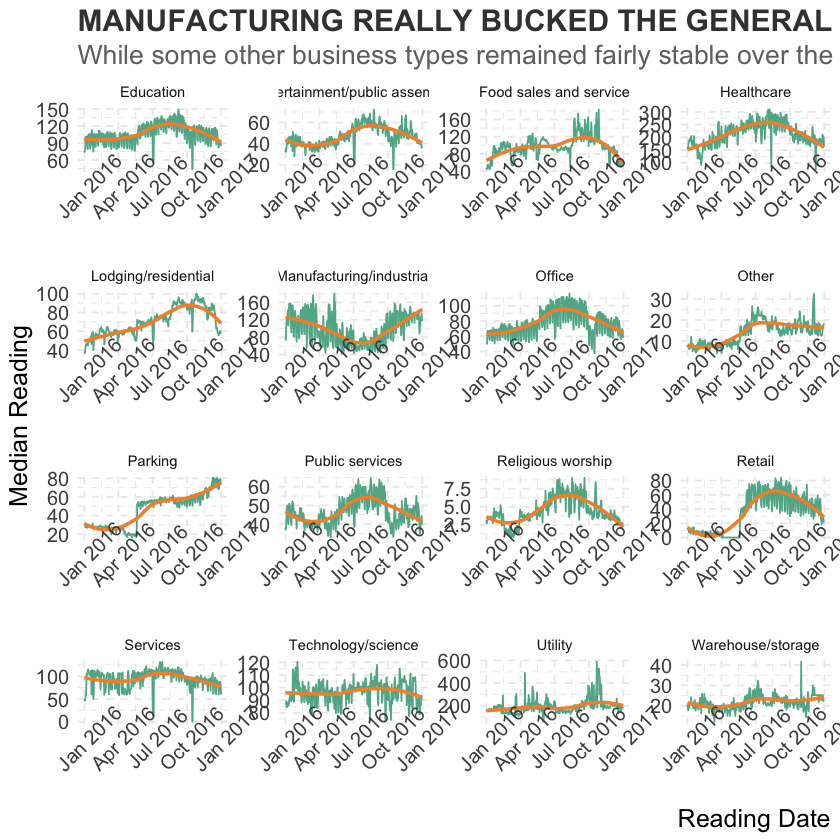

In [20]:
combine_train %>% 
  group_by(timestamp_date, primary_use) %>% 
  summarise(median_reading = median(meter_reading, na.rm = T)) %>% 
  ggplot(aes(x= timestamp_date, y= median_reading)) +
  geom_line(colour = "#5EB296") +
  geom_smooth(se = F, colour = col_pal[3]) +
  ggtitle("MANUFACTURING REALLY BUCKED THE GENERAL TREND", subtitle = "While some other business types remained fairly stable over the period") +
  labs(x= "Reading Date", y= "Median Reading") +
  facet_wrap(~ primary_use, scales = "free") +
  theme(axis.text.x = element_text(angle = 45))

### Correlation between meter_reading and Numeric Variables

Both the number of floors a building has and the size of the building have a fairly strong Pearson correlation with the meter_reading, ie, the bigger the building, the higher the reading. The year the building was built is also moderately strongle positively correlated - older buildings may have higher readings.

With a very weak negative Pearson correlation, wind_speed, air_temperature and cloud_coverage may be important in any model that gets built.

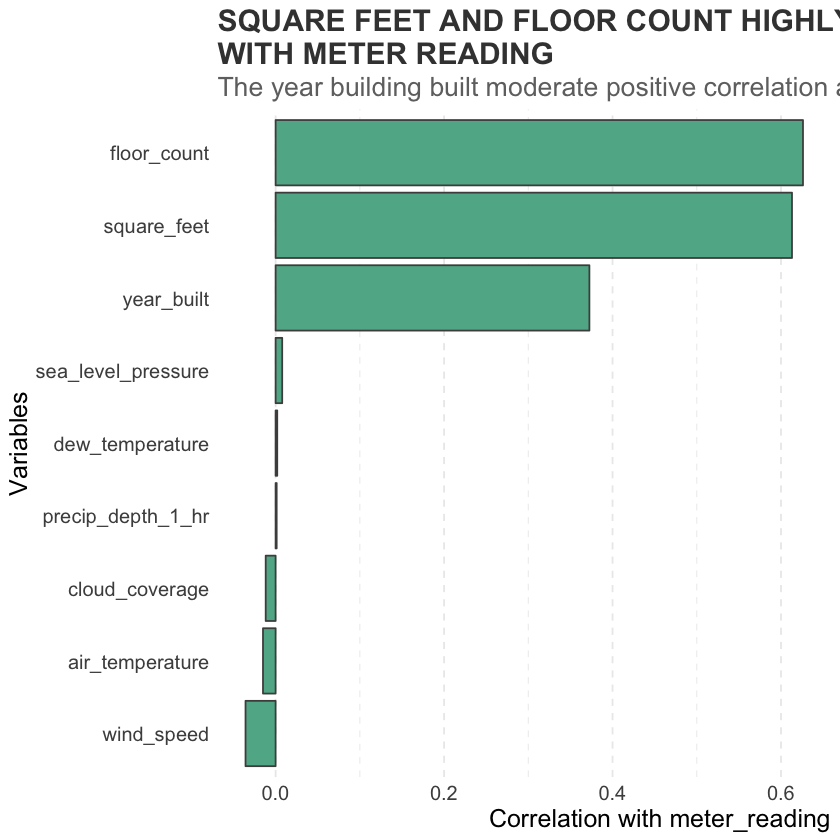

In [21]:
combine_train %>% 
  select(meter_reading, square_feet, year_built, floor_count, air_temperature, cloud_coverage, dew_temperature, precip_depth_1_hr, sea_level_pressure, wind_speed) %>% na.omit() %>% 
  as.matrix() %>% 
  cor() %>% as.data.frame() %>% 
  select(meter_reading) %>% mutate(vars = row.names(.)) %>% 
  filter(vars != "meter_reading") %>% 
  ggplot(aes(x= reorder(vars, meter_reading), y= meter_reading)) +
  geom_col(fill = "#5EB296", colour = col_pal[6]) +
  labs(x= "Variables", y= "Correlation with meter_reading") +
  ggtitle("SQUARE FEET AND FLOOR COUNT HIGHLY CORRELATED\nWITH METER READING", subtitle = "The year building built moderate positive correlation also") +
  coord_flip() +
  theme(panel.grid.major.y = element_blank())

### Visualising the Independent Variables
The independent variables (the variables we’ll use to help us predict meter_reading) will be analysed in this section. Analysing these variables also will allow us to see their distributions and if there are any issues with the data (missing variables, skeweness, extreme outliers, etc).

### Primary Use
There are 0 missing records in the primary_use variable.

Education building types are by far the most frequently read building types, while Office is a fair bit behind, but still almost double that of the third most read meters of Entertainment buildings.

There is a considerably long tail, with the bottom 11 being significantly lower.

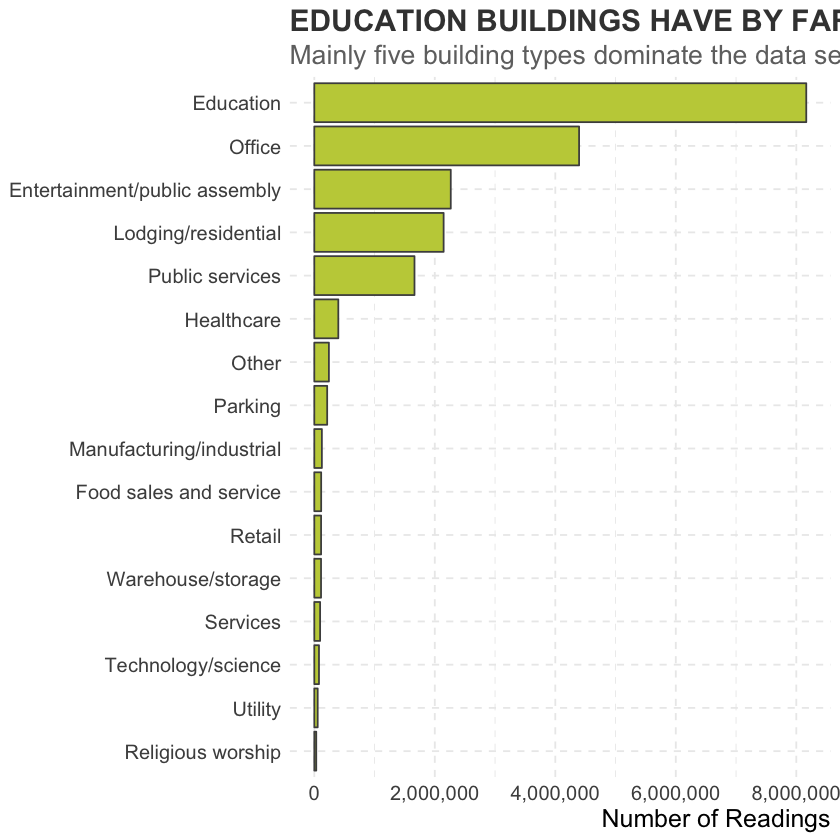

In [22]:
combine_train %>% 
  count(primary_use) %>% 
  ggplot(aes(x= reorder(primary_use, n), y= n)) +
  geom_col(colour = col_pal[6], fill = col_pal[4]) +
  scale_y_continuous(labels = comma) +
  labs(y= "Number of Readings") +
  ggtitle("EDUCATION BUILDINGS HAVE BY FAR THE MOST READINGS", subtitle = "Mainly five building types dominate the data set") +
  theme(axis.title.y = element_blank()) +
  coord_flip()

### Square Feet
There are 0 missing values in the square_feet variable.

The distribution of square feet is positively skewed, mith a median of 72,709 feet and mean of 107,783 square feet.

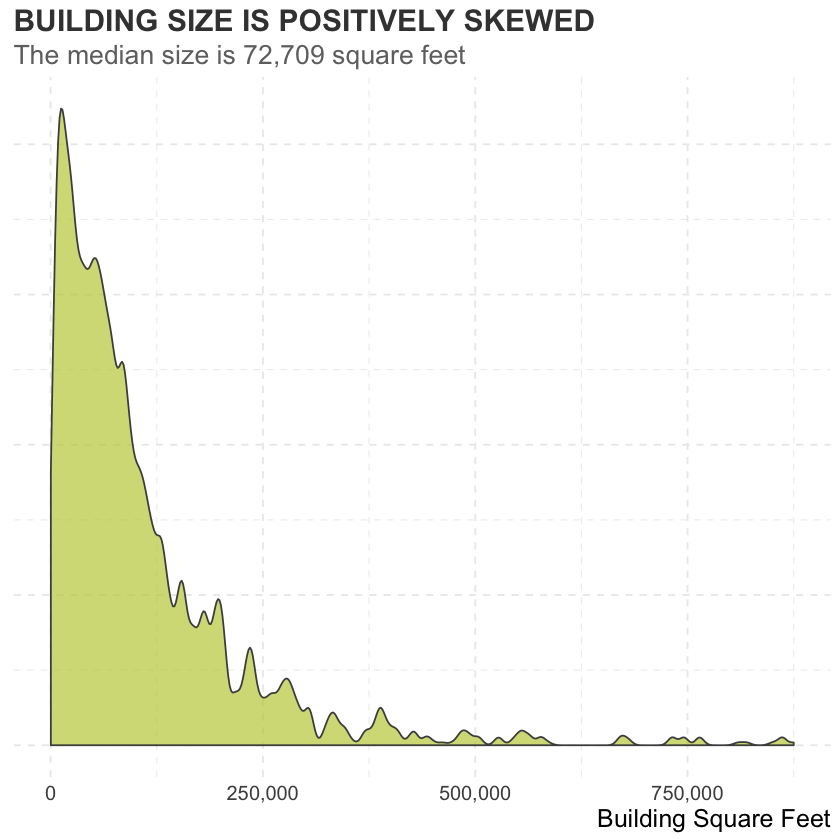

In [23]:
combine_train %>% 
  ggplot(aes(x= square_feet)) +
  geom_density(colour = col_pal[6], fill = col_pal[4], adjust = 2, alpha = 0.7) +
  scale_x_continuous(labels = comma, name = "Building Square Feet") +
  ggtitle("BUILDING SIZE IS POSITIVELY SKEWED", subtitle = paste0("The median size is ", comma(median(combine_train$square_feet)), " square feet")) +
  theme(axis.title.y = element_blank(), axis.text.y = element_blank())

### Meter

There are 0 missing records in the meter variable.

We can see that Electricity is read by far the most frequently, with over 12m records, while hotwater the other end had 1.26m records recorded.

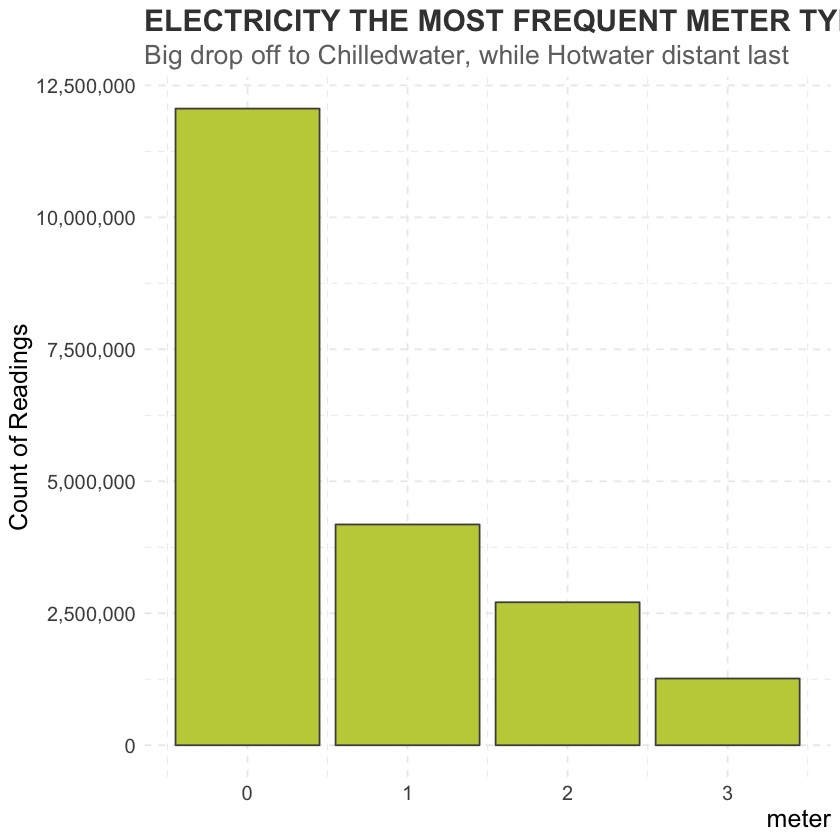

In [24]:
combine_train %>% 
  count(meter) %>% 
  ggplot(aes(x= meter, y= n)) +
  geom_col(colour = col_pal[6], fill = col_pal[4]) +
  scale_y_continuous(labels = comma, name = "Count of Readings") +
  ggtitle("ELECTRICITY THE MOST FREQUENT METER TYPE MEASURED", subtitle = "Big drop off to Chilledwater, while Hotwater distant last")

### Year Built

There are 12,127,645 missing records in the year_built variable.

These missing years are displayed below. Services building types do not have a year built recorded at all, while 11 of the 16 different types are missing over half.

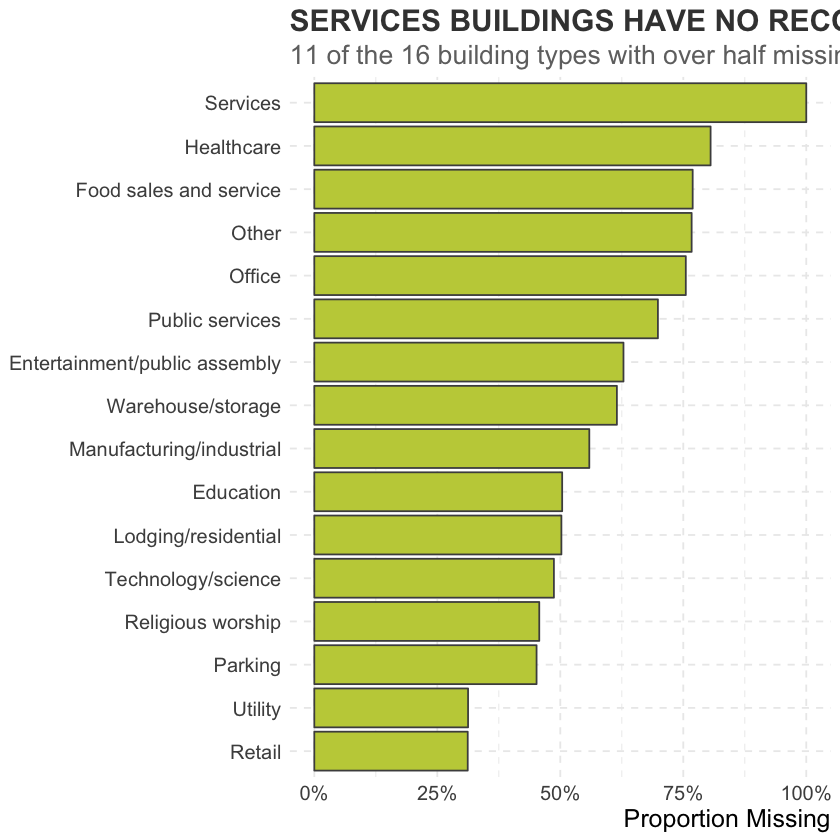

In [25]:
combine_train %>% 
  group_by(primary_use) %>% 
  summarise(n = n(),
            n_missing = sum(is.na(year_built))) %>% 
  mutate(proportion_missing = n_missing / n) %>% 
  ggplot(aes(x= reorder(primary_use, proportion_missing), y= proportion_missing)) +
  geom_col(colour = col_pal[6], fill = col_pal[4]) +
  scale_y_continuous(labels = percent) +
  labs(y= "Proportion Missing") +
  ggtitle("SERVICES BUILDINGS HAVE NO RECORDED YEAR BUILT", subtitle = "11 of the 16 building types with over half missing year built record") +
  theme(axis.title.y = element_blank()) +
  coord_flip()

Of the recorded year built, 1976 was the most frequent, with 55 buildings built.

Warning message:
“Removed 1 rows containing missing values (geom_path).”

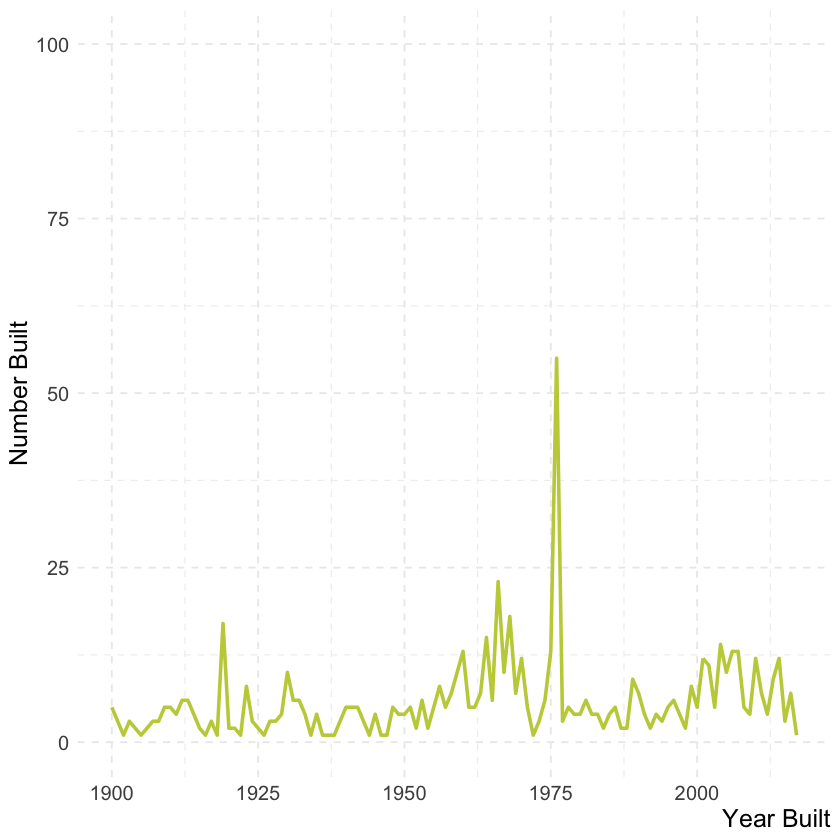

In [26]:
combine_train %>% 
  distinct(building_id, .keep_all = T) %>% 
  group_by(year_built) %>% 
  summarise(n_buildings = n()) %>%
  ggplot(aes(x= year_built, y= n_buildings)) +
  geom_line(colour = col_pal[4], size = 1) +
  scale_y_continuous(name = "Number Built", limits = c(0,100)) +
  labs(x= "Year Built")

### Floor Count

There are 16,709,167 missing records in the floor_count variable. Of the 1449 unique building IDs, 1094 don’t have a floor count.

Of those that do, we can see that there aren’t too many buildings with more than 10 floors, while the median number of floors is 3.

Warning message:
“Removed 1094 rows containing non-finite values (stat_density).”

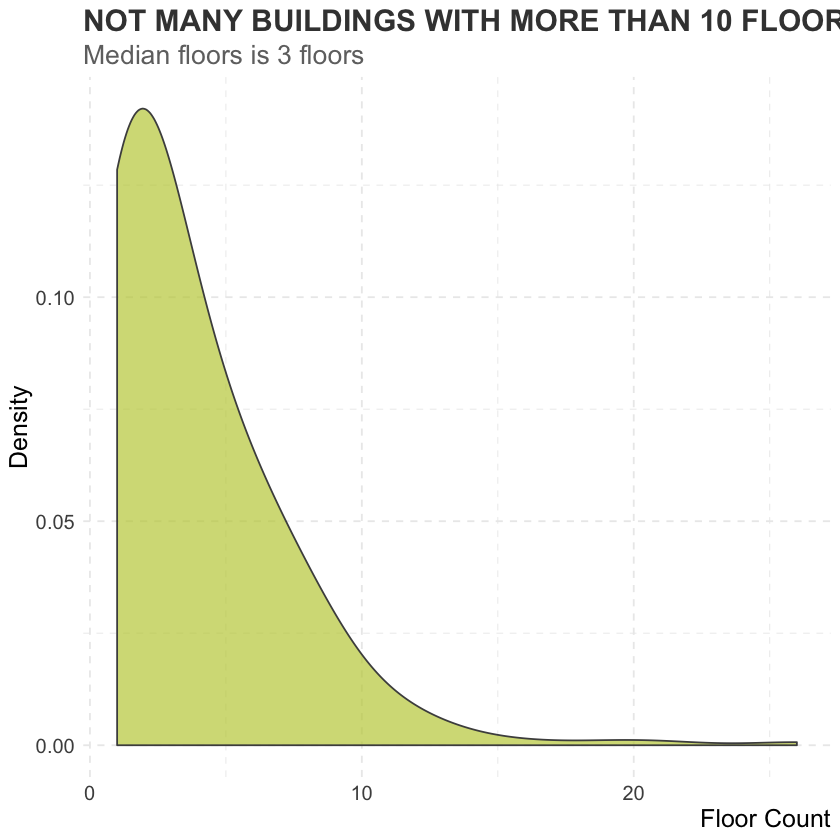

In [27]:
combine_train %>% 
  distinct(building_id, .keep_all = T) %>% 
  ggplot(aes(x= floor_count)) +
  geom_density(adjust = 2, colour = col_pal[6], fill = col_pal[4], alpha = 0.7) +
  labs(x= "Floor Count", y= "Density") +
  ggtitle("NOT MANY BUILDINGS WITH MORE THAN 10 FLOORS", subtitle = paste0("Median floors is ", median(combine_train$floor_count, na.rm = T), " floors"))

### Air Temperature

There are 96,658 missing air_temperature records in our combined training set, however, there are only 55 missing air temp records in the weather_train data set. I will create a function to fill these missing values.

Filling these missing values will not be a simple mean/median imputation, but rather a two step process:

Take the air_temperature value for the last timestamp as the next timestamps value
If the previous timestamp is also NA, then take the average of that day’s temperature for that particular site_id
Following this process results in no further NAs in the air_temperature variable.

Conveniently, the function can also be applied to dew_temperature also using dplyr::enquo.

In [28]:
fill_missing_temp <- function(df, temp_var) {
  
  temp_var <- enquo(temp_var)
  
  df %>% 
    arrange(site_id, timestamp) %>% 
    group_by(site_id) %>% 
    mutate(last_temp = lag(!! temp_var)) %>% 
    ungroup() %>% 
    mutate(month_day = paste0(timestamp_month, "_", timestamp_day)) %>% 
    group_by(site_id, month_day) %>% 
    mutate(avg_daily_temp = mean(!! temp_var, na.rm = T)) %>%  
    ungroup() %>% 
    mutate(temp_clean = ifelse(is.na(!! temp_var), last_temp, !! temp_var),
           temp_clean = ifelse(is.na(temp_clean), avg_daily_temp, temp_clean)) %>% 
    select(-last_temp, -avg_daily_temp) %>% 
    pull(temp_clean)
  
} 


# now apply to the combined DF
combine_train$air_temp_clean <- fill_missing_temp(combine_train, air_temperature)

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~13 and 25 degrees.

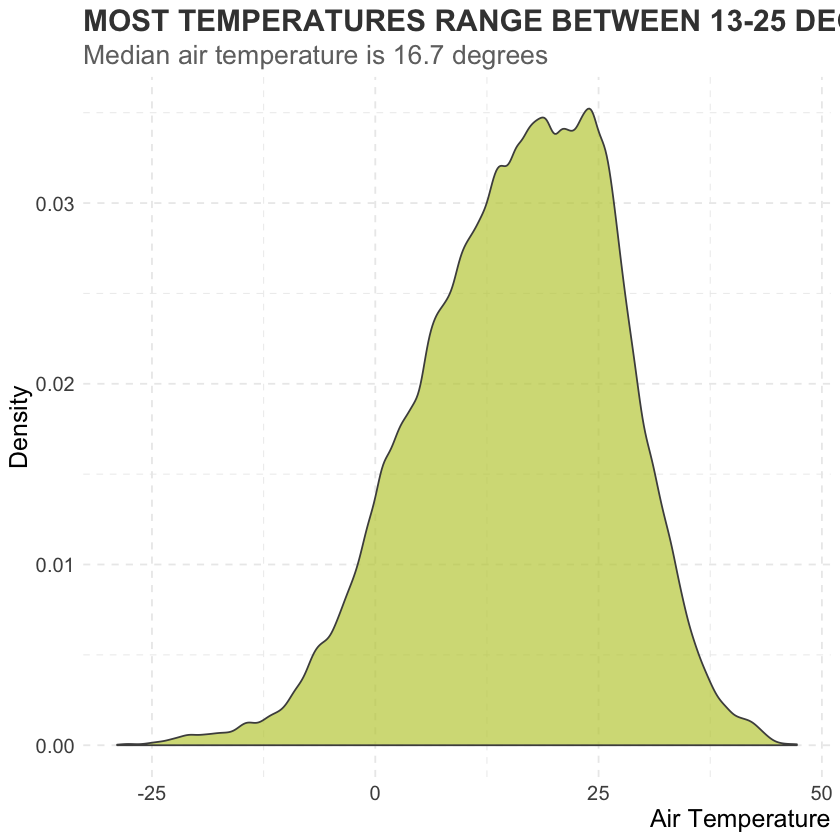

In [29]:
combine_train %>% 
  ggplot(aes(x= air_temp_clean)) +
  geom_density(adjust = 2, colour = col_pal[6], fill = col_pal[4], alpha = 0.7) +
  labs(x= "Air Temperature", y= "Density") +
  ggtitle("MOST TEMPERATURES RANGE BETWEEN 13-25 DEGREES", subtitle = paste0("Median air temperature is ", median(combine_train$air_temp_clean, na.rm = T), " degrees"))

### Dew Temperature

There are 100,140 missing dew_temperature records in our combined training set. The function created above can be applied to fill these missing values.

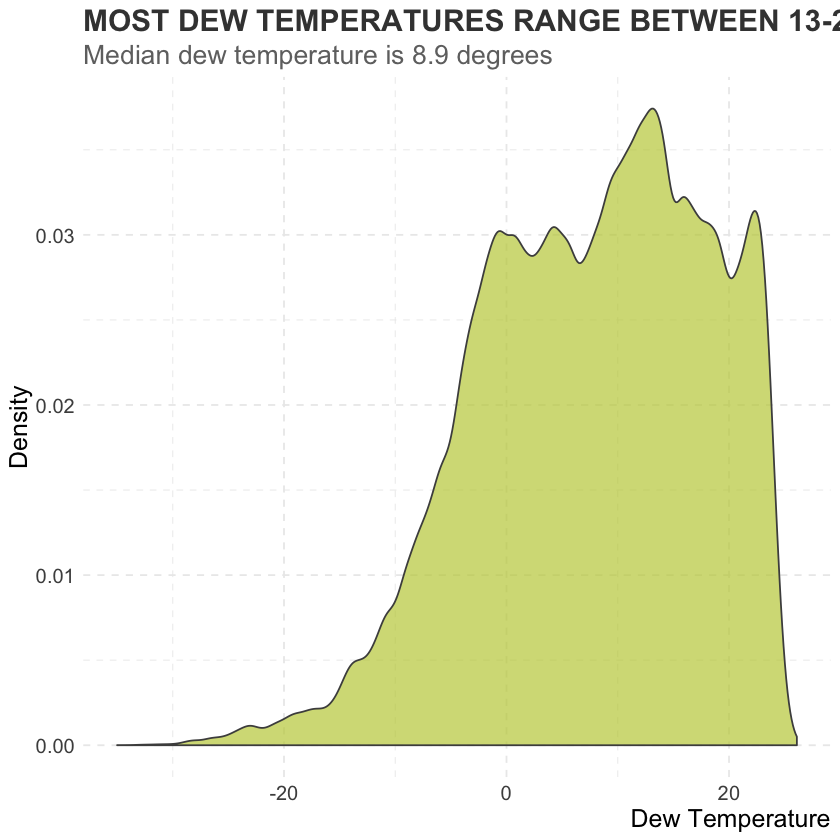

In [30]:
combine_train$dew_temp_clean <- fill_missing_temp(combine_train, dew_temperature) 

combine_train %>% 
  ggplot(aes(x= dew_temp_clean)) +
  geom_density(adjust = 2, colour = col_pal[6], fill = col_pal[4], alpha = 0.7) +
  labs(x= "Dew Temperature", y= "Density") +
  ggtitle("MOST DEW TEMPERATURES RANGE BETWEEN 13-25 DEGREES", subtitle = paste0("Median dew temperature is ", median(combine_train$dew_temp_clean, na.rm = T), " degrees"))

In [31]:
fit <- lm(meter_reading ~ square_feet + year_built + floor_count, data=combine_train)
summary(fit)


Call:
lm(formula = meter_reading ~ square_feet + year_built + floor_count, 
    data = combine_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-2419.7  -136.9    -2.8    48.8 22496.2 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.217e+02  3.133e+01  -3.886 0.000102 ***
square_feet  3.367e-03  3.816e-06 882.313  < 2e-16 ***
year_built   3.796e-02  1.603e-02   2.369 0.017854 *  
floor_count -8.229e+00  1.255e-01 -65.584  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 659.3 on 2263473 degrees of freedom
  (17952623 observations deleted due to missingness)
Multiple R-squared:  0.3365,	Adjusted R-squared:  0.3365 
F-statistic: 3.827e+05 on 3 and 2263473 DF,  p-value: < 2.2e-16


In [32]:
coefficients(fit) # model coefficients
confint(fit, level=0.95) # CIs for model parameters

(Intercept)   square_feet    year_built   floor_count 
-1.217414e+02  3.367184e-03  3.796263e-02 -8.228891e+00

,2.5 %,97.5 %
(Intercept),-1.831382e+02,-60.344692801
square_feet,3.359704e-03,0.003374663
year_built,6.549821e-03,0.069375448
floor_count,-8.474812e+00,-7.982971409


In [33]:
anova(fit) # anova table

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
square_feet,1,497109873906,4.971099e+11,1.143716e+06,0.000000000
year_built,1,3737561,3.737561e+06,8.599125e+00,0.003363279
floor_count,1,1869499456,1.869499e+09,4.301217e+03,0.000000000
Residuals,2263473,983805729827,4.346443e+05,NA,NA


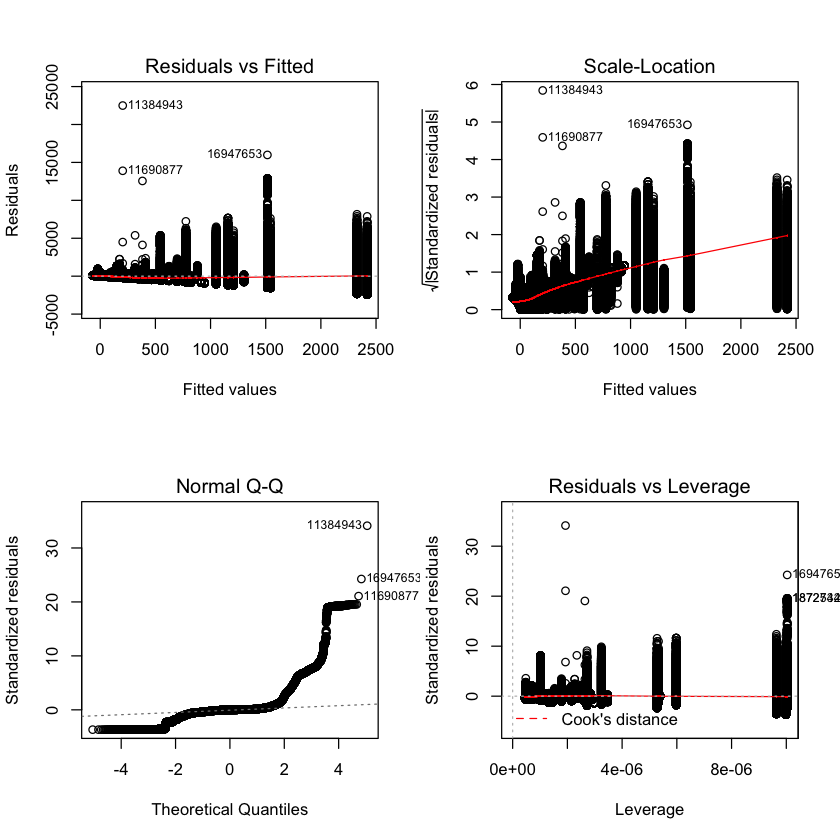

In [34]:
# diagnostic plots
layout(matrix(c(1,2,3,4),2,2)) # optional 4 graphs/page
plot(fit)

In [35]:
install.packages("Metrics")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [36]:
library(Metrics)

In [37]:
mae(combine_train$meter_reading, predict(fit))
mse(combine_train$meter_reading, predict(fit))
rmse(combine_train$meter_reading, predict(fit))

Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”

[1] 2250.465

Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”

[1] 23484688797

Warning message in actual - predicted:
“longer object length is not a multiple of shorter object length”

[1] 153247.1

## Decision Tree

In [38]:
library(rpart)

In [40]:
fit <- rpart(meter_reading~floor_count + square_feet + year_built,
   method="anova", data=combine_train)

printcp(fit) # display the results


Regression tree:
rpart(formula = meter_reading ~ floor_count + square_feet + year_built, 
    data = combine_train, method = "anova")

Variables actually used in tree construction:
[1] square_feet

Root node error: 4.747e+17/20216100 = 2.3481e+10

n= 20216100 

       CP nsplit rel error xerror    xstd
1 0.06723      0   1.00000 1.0000 0.02403
2 0.01000      2   0.86554 0.8657 0.01904


Call:
rpart(formula = meter_reading ~ floor_count + square_feet + year_built, 
    data = combine_train, method = "anova")
  n= 20216100 

          CP nsplit rel error    xerror       xstd
1 0.06723002      0   1.00000 1.0000002 0.02403028
2 0.01000000      2   0.86554 0.8657003 0.01903953

Variable importance
square_feet 
        100 

Node number 1: 20216100 observations,    complexity param=0.06723002
  mean=2117.121, MSE=2.348116e+10 
  left son=2 (19263118 obs) right son=3 (952982 obs)
  Primary splits:
      square_feet < 332665.5 to the left,  improve=2.608278e-03, (0 missing)
      floor_count < 10.5     to the left,  improve=3.778068e-07, (16709167 missing)
      year_built  < 2005.5   to the left,  improve=1.481944e-07, (12127645 missing)

Node number 2: 19263118 observations
  mean=376.4539, MSE=1.608699e+07 

Node number 3: 952982 observations,    complexity param=0.06723002
  mean=37302.13, MSE=4.964935e+11 
  left son=6 (935416 obs) right son=7 (17566 obs)
  Primary spli

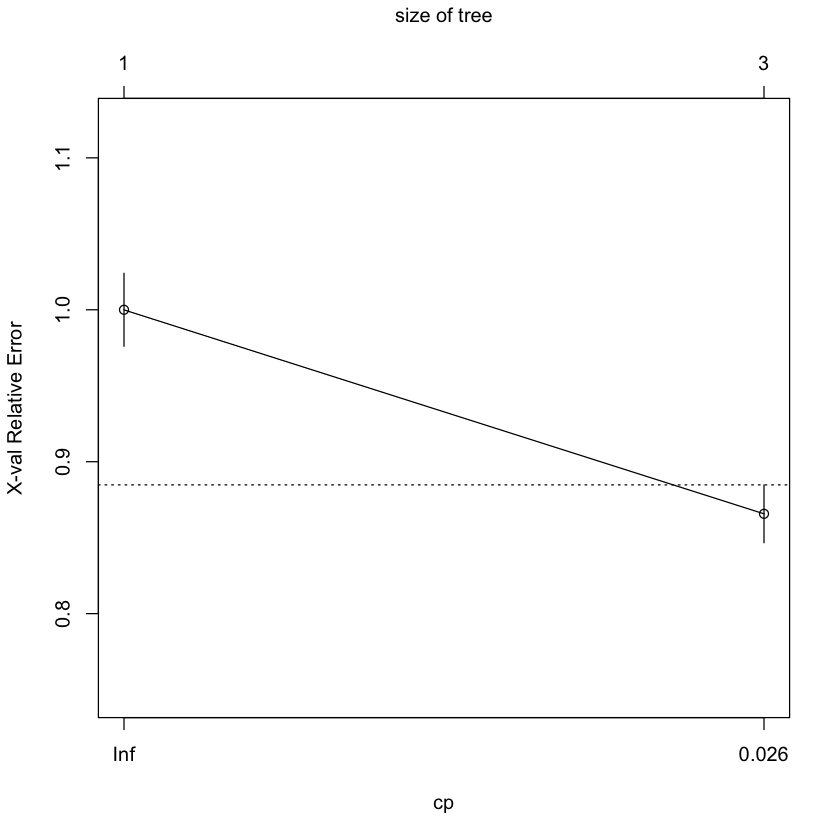

In [41]:
plotcp(fit) # visualize cross-validation results
summary(fit) # detailed summary of splits


Regression tree:
rpart(formula = meter_reading ~ floor_count + square_feet + year_built, 
    data = combine_train, method = "anova")

Variables actually used in tree construction:
[1] square_feet

Root node error: 4.747e+17/20216100 = 2.3481e+10

n= 20216100 

       CP nsplit rel error xerror    xstd
1 0.06723      0   1.00000 1.0000 0.02403
2 0.01000      2   0.86554 0.8657 0.01904


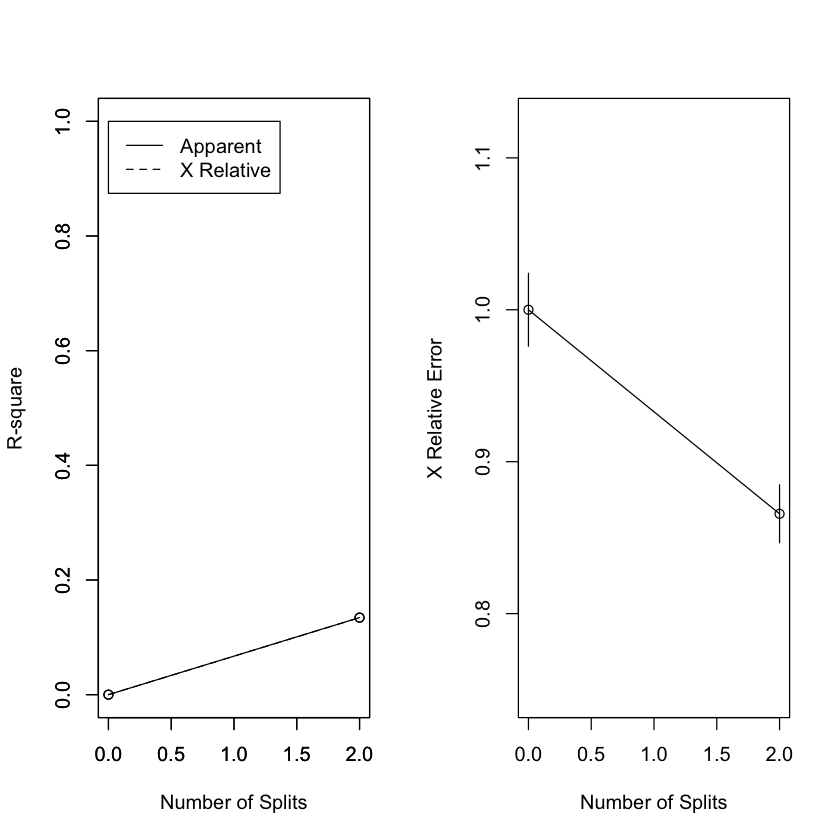

In [42]:
# create additional plots
par(mfrow=c(1,2)) # two plots on one page
rsq.rpart(fit) # visualize cross-validation results

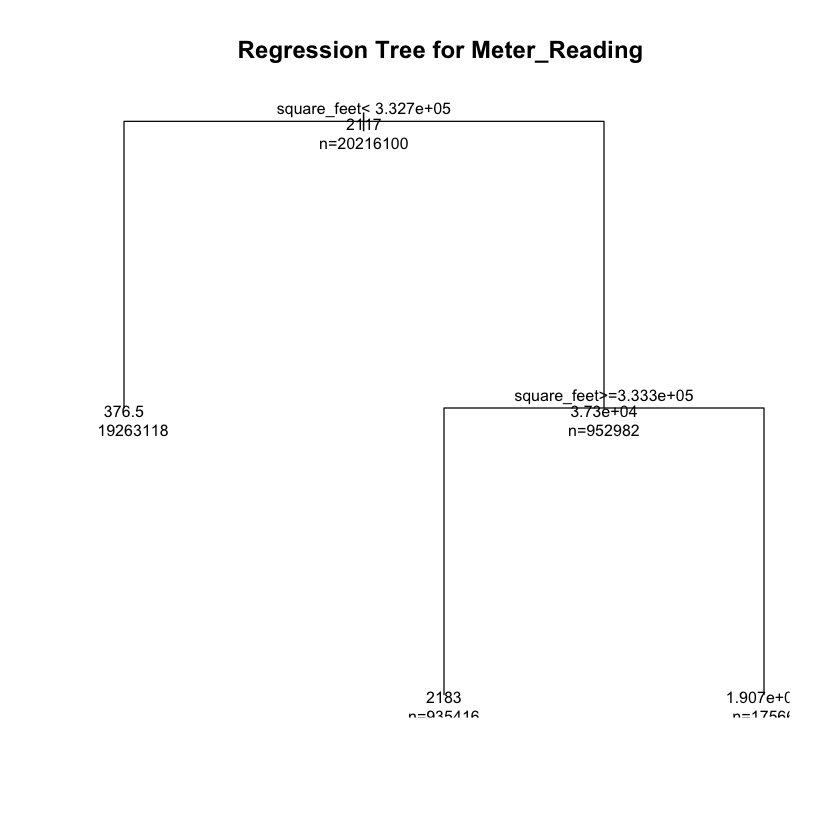

In [44]:
# plot tree
plot(fit, uniform=TRUE,
   main="Regression Tree for Meter_Reading ")
text(fit, use.n=TRUE, all=TRUE, cex=.8)

In [ ]:
# prune the tree
pfit<- prune(fit, cp=0.01160389) # from cptable   

# plot the pruned tree
plot(pfit, uniform=TRUE,
   main="Pruned Regression Tree for Meter_Reading")
text(pfit, use.n=TRUE, all=TRUE, cex=.8)

In [ ]:
# Random Forest prediction of Combine_Train
library(randomForest)
fit <- randomForest(meter_reading ~ square_feet + year_built + floor_count,   data=combine_train)
print(fit) # view results
importance(fit) # importance of each predictor